In [7]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import os
import transformers
from accelerate import Accelerator

os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
accelerator = Accelerator()
device = accelerator.device

In [82]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_blocks=5, bottleneck_dim=64):
        super(MLP, self).__init__()
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        self.layers = nn.ModuleList()
        for _ in range(num_blocks):
            shortcut_layers = []
            shortcut_layers.append(nn.Linear(hidden_dim, bottleneck_dim))
            shortcut_layers.append(nn.Dropout())
            shortcut_layers.append(nn.ReLU())  # Using ReLU for simplicity; you can choose other activations as needed
            shortcut_layers.append(nn.Linear(bottleneck_dim, bottleneck_dim))
            shortcut_layers.append(nn.Dropout())
            shortcut_layers.append(nn.ReLU())
            shortcut_layers.append(nn.Linear(bottleneck_dim, hidden_dim))
            shortcut_layers.append(nn.Dropout())
            self.layers.append(nn.Sequential(*shortcut_layers))

        self.output_layer= nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = self.input_layer(x)
        for layer in self.layers:
            x = x + layer(x) # shortcut
        return self.output_layer(x)

def pairwise_cosine_similarity(Q, K):
    attention_scores = torch.matmul(Q, K.transpose(-2, -1)) #[N, P, L]
    # denominator = torch.sqrt((Q**2).sum(-1).unsqueeze(-1) * (K**2).sum(-1).unsqueeze(-2))
    denominator = (K**2).sum(-1).unsqueeze(-2)
    attention_weights = attention_scores / (denominator + 1e-5)
    return attention_weights

class SimplifiedAttention(nn.Module):
    def __init__(self, embed_size):
        super(SimplifiedAttention, self).__init__()
        self.query = nn.Linear(embed_size, embed_size)
        self.key = nn.Linear(embed_size, embed_size)
        self.value = nn.Linear(embed_size, embed_size)
    
    def forward(self, q, k, v, reduce=False):
        assert len(q.shape) in (2, 3), "The query tensor must be 2 or 3 dimensional."
        if len(q.shape) == 2:
            # Q = self.query(q).unsqueeze(1) # [N, P, d], P = 1
            Q = q.unsqueeze(1)
        else:
            # Q = self.query(q) # [N, P, d] , P: prediction length
            Q = q
        # K = self.key(k) # [N, L, d]
        K = k
        # V = self.value(v) # [N, L, d]
        V = v
        
        # Compute the attention scores [N, P, L]
        # attention_scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(Q.size(-1), dtype=torch.float32))
        # attention_scores = torch.matmul(Q, K.transpose(-2, -1))
        attention_weights = pairwise_cosine_similarity(Q, K)
        
        # Apply softmax to get the attention weights
        # attention_weights = F.softmax(attention_scores, dim=-1) # [N, P, L]
        # attention_weights = F.normalize(attention_scores, p=2, dim=-1)
        
        # Compute the weighted sum of values using the attention weights
        if reduce:
            attention_outputs = torch.matmul(attention_weights, V) # [N, P, d]
        else:
            attention_outputs = torch.einsum('bij,bjk->bijk', attention_weights, V) # [N, P, L] x [N, L, d] --> [N, P, L, d]
            # attention_outputs = V # [N, L, d]

        return attention_outputs, attention_weights  # Return both weights and outputs

# import collections
# class SurrogatePatchEmbeddings(nn.Module):
#     """
#     This class turns `pixel_values` of shape `(batch_size, num_channels, height, width)` into
#     patches of shape `(batch_size, seq_length, patch_height, patch_width)` to be consumed by a
#     surrogate model.
#     """

#     def __init__(self, config):
#         super().__init__()
#         image_size, patch_size = config.image_size, config.patch_size
#         num_channels, hidden_size = config.num_channels, config.hidden_size

#         image_size = image_size if isinstance(image_size, collections.abc.Iterable) else (image_size, image_size)
#         patch_size = patch_size if isinstance(patch_size, collections.abc.Iterable) else (patch_size, patch_size)
#         num_patches = (image_size[1] // patch_size[1]) * (image_size[0] // patch_size[0])
#         self.image_size = image_size
#         self.patch_size = patch_size
#         self.num_channels = num_channels
#         self.num_patches = num_patches

#         self.projection = nn.Conv2d(num_channels, hidden_size, kernel_size=patch_size, stride=patch_size)

#     def forward(self, pixel_values: torch.Tensor, interpolate_pos_encoding: bool = False) -> torch.Tensor:
#         batch_size, num_channels, height, width = pixel_values.shape
#         if num_channels != self.num_channels:
#             raise ValueError(
#                 "Make sure that the channel dimension of the pixel values match with the one set in the configuration."
#                 f" Expected {self.num_channels} but got {num_channels}."
#             )
#         if not interpolate_pos_encoding:
#             if height != self.image_size[0] or width != self.image_size[1]:
#                 raise ValueError(
#                     f"Input image size ({height}*{width}) doesn't match model"
#                     f" ({self.image_size[0]}*{self.image_size[1]})."
#                 )
#         embeddings = self.projection(pixel_values).flatten(2).transpose(1, 2)
#         return embeddings

class SurrogateInterpretation(nn.Module):
    def __init__(self, pred_model, classifier_head, input_embed, hidden_size) -> None:
        """
        pred_model: prediction model
        classifier_head: last fully connected layer 
        """
        super().__init__()

        self.pred_model = pred_model

        # Input embedding, it doesn't necessarily be an embedding per se. 
        # It used to convert the input to a form of list of token tensors.
        self.input_embed = input_embed

        # Classifier head
        self.classifier = classifier_head
        # Transform function to non-linearly transform patch embedding to the representation space
        self.transform_func = MLP(input_dim=hidden_size,
                                  hidden_dim=hidden_size,
                                  output_dim=hidden_size,
                                  num_blocks=5,
                                  bottleneck_dim=64)
        self.attention = SimplifiedAttention(embed_size=hidden_size)

        # freeze parameters of the prediction model.
        if True:
            self.freeze_params()
        
        self.sim_loss_func = nn.MSELoss()
        self.cls_loss_func = nn.CrossEntropyLoss()
        self.kl_loss = torch.nn.KLDivLoss(reduction='batchmean', log_target=True)
        self.cossim_loss_func = nn.CosineSimilarity(dim=-1)
    
    def freeze_params(self,):
        for name, param in self.pred_model.named_parameters():
            param.requires_grad = False 
            # print(f"freezed {name}")
        for param in self.classifier.parameters():
            param.requires_grad = False   
        for param in self.input_embed.parameters():
            param.requires_grad = False   
        return 
    
    def compute_loss(self, pred_out, pseudo_label_out, pred, pseudo_label):
        # assert len(last_cls_hidden_state.shape) in (2, 3), "The last hidden state should be of shape [N, L, d] or [N, d]"
        # if len(last_cls_hidden_state.shape) == 2:
        #     last_cls_hidden_state = last_cls_hidden_state.unsqueeze(1) # convert to [N, 1, d]

        # assert len(pseudo_label.shape) in (2, 3), "The last hidden state should be of shape [N, L, d] or [N, d]"
        # if len(pseudo_label.shape) == 2:
        #     pseudo_label = pseudo_label.unsqueeze(1) # convert to [N, 1, d]
        
        # sim_loss = self.sim_loss_func(pred_out, pseudo_label_out)
        cls_loss = self.cls_loss_func(pred, pseudo_label)
        # kl_loss = self.kl_loss(F.log_softmax(pred_out, dim=-1), F.log_softmax(pseudo_label_out, dim=-1))
        cos_sim = - self.cossim_loss_func(pred_out, pseudo_label_out).mean()

        loss = cls_loss + 1 * cos_sim

        return {'loss':loss, 
                'cls_loss': cls_loss,
                'cos_sim': cos_sim}
        
    
    def forward(self, pixel_values, labels=None):
        outputs = self.pred_model(pixel_values=pixel_values, output_hidden_states=True) 
        last_cls_hidden_state = outputs['hidden_states'][-1][:,0,:] # [N, d] the last hidden state of the cls token
        patch_embeddings = self.input_embed(pixel_values=pixel_values) # [N, L, d]
        
        
        patch_reprs = self.transform_func(patch_embeddings)
        attention_output_split, attention_weights = self.attention(
            last_cls_hidden_state,
            patch_reprs,
            patch_reprs,
        ) # attention_weight [N, P, L], attention_output [N, P, d], 
        attention_output = attention_output_split.sum(dim=-2) # dim=-2 for reducing the output as the sum of all interpretable features

        pseudo_label_out = self.classifier(last_cls_hidden_state)
        pseudo_label = pseudo_label_out.argmax(-1)
        pseudo_label_out = pseudo_label_out.contiguous().view(-1, pseudo_label_out.shape[-1])
        pseudo_label = pseudo_label.contiguous().view( pseudo_label.shape[-1])
        # print(last_cls_hidden_state.shape)
        # print(pseudo_label)
        # TODO fix
        # attention_output = torch.sum(patch_reprs, dim=1, keepdim=True)
        # TODO fix

        # pred = self.classifier(attention_output) # [N, L, out]
        # pred = torch.softmax(pred, dim=-1) # [N, L, out]
        # pred = torch.matmul(attention_weights, pred)  # [N, P, out]
        pred = self.classifier(attention_output) # [N, P, out]

        pred = pred.contiguous().view(-1, pred.shape[-1])
        # print(pred.shape)

        loss_dict = self.compute_loss(pred, pseudo_label_out, pred, pseudo_label)
        # loss_dict = self.compute_loss(attention_output.contiguous().view(-1, attention_output.shape[-1]), 
        #                               last_cls_hidden_state.contiguous().view(-1, last_cls_hidden_state.shape[-1]), 
        #                               pred, 
        #                               pseudo_label)
        loss = loss_dict['loss']

        pred_labels = pred.argmax(-1).view(-1)
        correct = (pred_labels == pseudo_label).sum()
        accuracy = correct / len(pred_labels)

        if labels is not None:
            pred_accuracy = (pseudo_label == labels).sum() / len(labels)
            outputs['pred_acc'] = pred_accuracy

        outputs['patch_reprs'] = patch_reprs
        outputs['attention_output'] = attention_output
        outputs['attention_weights'] = attention_weights
        outputs['last_hidden_state'] = last_cls_hidden_state
        outputs['loss'] = loss
        outputs['cossim_loss'] = loss_dict['cos_sim']
        outputs['cls_loss'] = loss_dict['cls_loss']
        outputs['acc'] = accuracy
        outputs['attention_output_split'] = attention_output_split
        
        return outputs

In [83]:
from torchvision.transforms import (CenterCrop, Compose, Normalize, RandomHorizontalFlip, RandomResizedCrop, Resize, ToTensor)
from transformers import ViTImageProcessor, ViTForImageClassification, ViTConfig


pretrained_name = 'google/vit-base-patch16-224'
config = ViTConfig.from_pretrained(pretrained_name)
processor = ViTImageProcessor.from_pretrained(pretrained_name)

image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]

normalize = Normalize(mean=image_mean, std=image_std)
_train_transforms = Compose(
    [
        RandomResizedCrop(size),
        RandomHorizontalFlip(),
        ToTensor(),
        Normalize(mean=image_mean, std=image_std)
    ]
)

_val_transforms = Compose(
    [
        Resize(size),
        CenterCrop(size),
        ToTensor(),
        Normalize(mean=image_mean, std=image_std)
    ]
)

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert('RGB')) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert('RGB')) for image in examples['image']]
    return examples

In [84]:
from datasets import load_dataset
dataset = load_dataset("mrm8488/ImageNet1K-val")
dataset = dataset['train']
splits = dataset.train_test_split(test_size=0.1)
train_ds = splits['train']
val_ds = splits['test']
train_ds.set_transform(train_transforms)
val_ds.set_transform(val_transforms)

from torch.utils.data import DataLoader

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example['label'] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

test_dataloader = DataLoader(val_ds, collate_fn=collate_fn, batch_size=16, shuffle=False)


Repo card metadata block was not found. Setting CardData to empty.


In [85]:
pred_model = ViTForImageClassification.from_pretrained(pretrained_name)
pred_model.to(device)

input_embed = pred_model.get_input_embeddings()
classifier_head = pred_model.classifier
hidden_size = config.hidden_size
model = SurrogateInterpretation(pred_model=pred_model, classifier_head=classifier_head, input_embed=input_embed, hidden_size=hidden_size)
model.to(device)

model_name = 'vit_sur_loss=cls+cos_att=cossim2.pt'
model.load_state_dict(torch.load(f'model/{model_name}'))

<All keys matched successfully>

### Obtain interpretations

In [86]:
# obtain interpretations
examples = next(iter(test_dataloader))

In [89]:
model.train() ## TODO: important, why need train()? 应该是因为在训练的时候不应把pred model放入模型使之也收到train()影响
with torch.no_grad():
    pixel_values = examples['pixel_values'].to(device)
    labels = examples['labels'].to(device)
    outputs = model(pixel_values, labels)
    prediction = model.classifier(outputs.last_hidden_state).argmax(-1)
    int_prediction = model.classifier(outputs.attention_output).argmax(-1).reshape(-1)
    print('prediction:', prediction)
    print('int_prediction', int_prediction)


prediction: tensor([954, 673, 548, 773, 764, 630, 332, 385, 189, 868, 514, 785, 586, 561,
        406, 493], device='mps:0')
int_prediction tensor([953, 673, 548, 503, 764, 630, 332, 385, 189, 868, 655, 785, 586, 561,
        406, 493], device='mps:0')


In [200]:
attention_output_split = outputs['attention_output_split'].sum(1)
attribution_split = model.classifier(attention_output_split) - model.classifier.bias
attribution_split.shape

torch.Size([16, 196, 1000])

In [201]:
model.classifier(outputs.attention_output)

tensor([[[ 5.9126,  3.7650, -1.6981,  ...,  1.5185,  7.2744, -3.8476]],

        [[-7.5011,  0.3995, -5.8748,  ...,  2.3498,  3.5344,  0.5895]],

        [[-1.5537,  2.8976, -1.6212,  ..., -2.9255, -5.8465,  0.2583]],

        ...,

        [[-2.3230, -3.0435, -2.6339,  ...,  0.2466, -4.1359, -4.9273]],

        [[ 1.8202, -7.7396,  0.6881,  ..., -3.7236, -6.3847,  5.1765]],

        [[ 0.6981, -2.5045, -3.5193,  ..., -3.1090,  3.2865, 14.6715]]],
       device='mps:0')

In [202]:
attribution_split.sum(-2) + model.classifier.bias

tensor([[ 5.9126,  3.7650, -1.6981,  ...,  1.5185,  7.2744, -3.8476],
        [-7.5012,  0.3995, -5.8748,  ...,  2.3498,  3.5344,  0.5895],
        [-1.5537,  2.8976, -1.6212,  ..., -2.9255, -5.8465,  0.2583],
        ...,
        [-2.3230, -3.0435, -2.6339,  ...,  0.2466, -4.1359, -4.9273],
        [ 1.8202, -7.7396,  0.6881,  ..., -3.7236, -6.3847,  5.1765],
        [ 0.6981, -2.5045, -3.5193,  ..., -3.1090,  3.2865, 14.6715]],
       device='mps:0')

In [203]:
def idx_to_selector(idx_tensor, selection_size):
    """
    Convert a labels indices tensor of shape [batch_size] 
    to one-hot encoded tensor [batch_size, selection_size]

    """
    batch_size = idx_tensor.shape[0]
    dummy = torch.arange(selection_size, device=idx_tensor.device).unsqueeze(0).expand(batch_size, -1)
    extended_idx_tensor = idx_tensor.unsqueeze(-1).expand(-1, selection_size)
    return (dummy == extended_idx_tensor).float()
# attribution_split[:, :, prediction].shape
selector = idx_to_selector(prediction, 1000)
importance = (selector.unsqueeze(1) * attribution_split).sum(-1)
importance.shape

torch.Size([16, 196])

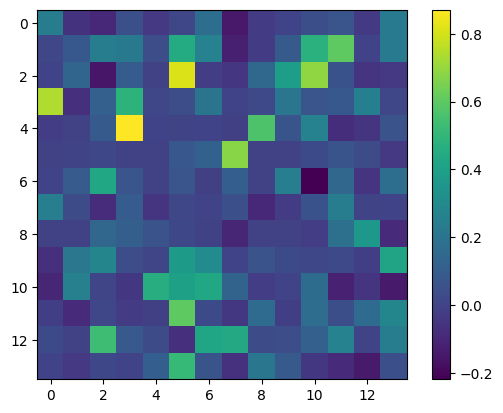

In [219]:
import matplotlib.pyplot as plt
idx = 0
plt.imshow(importance[idx].reshape(14,14).cpu().numpy())
# Add a color bar
plt.colorbar()

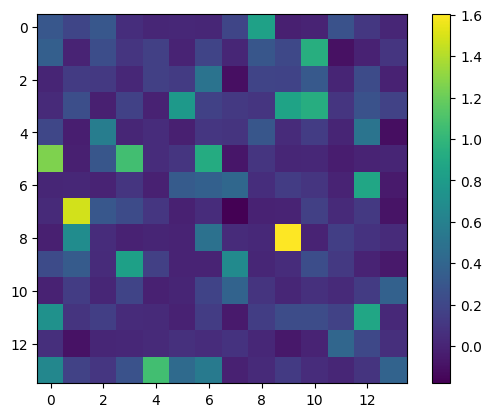

In [223]:
import matplotlib.pyplot as plt
idx = 1
plt.imshow(importance[idx].reshape(14,14).cpu().numpy())
# Add a color bar
plt.colorbar()

In [220]:
examples['labels']

tensor([954, 673, 548, 773, 683, 630, 332, 385, 189, 647, 515, 785, 847, 561,
        887, 493])

mouse, computer mouse


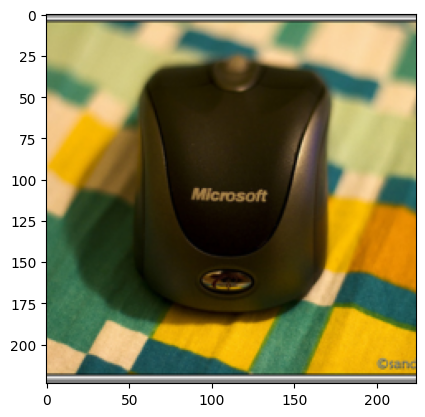

In [224]:
def unnormalize(img, mean, std):
    return img * std + mean

import matplotlib.pyplot as plt
example = examples['pixel_values'][idx].cpu().numpy().transpose(1, 2, 0)
label = examples['labels'][idx].cpu().numpy()
example = unnormalize(example, image_mean, image_std)
print(config.id2label[label.item()])
plt.imshow(example)

In [222]:
label.item()

954